# Example stuff from Matt's ali_offline_demod.py

#### packages he loads: 

In [18]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
import scipy

from scipy.signal import sawtooth, square, savgol_filter
import pandas as pd
import glob as gl
import os
import cmath

from scipy.signal import sawtooth, square,find_peaks
from scipy import spatial
# import lambdafit as lf
from scipy.interpolate import CubicSpline,interp1d
import h5py

from tqdm import tqdm as tqdm_terminal
from tqdm.notebook import trange, tqdm_notebook
from scipy.signal.windows import hann

from scipy.fft import fft, ifft, fftfreq
from copy import deepcopy
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import curve_fit

### current read_data function

In [19]:
#Functions for reading, processing, and demodulating real data
def read_data(filename,channels='all',start_channel=0,stop_channel=1000):
    if channels == 'all':
        file = h5py.File(filename, 'r')
        # making arrays 
        adc_i = np.array(file['time_ordered_data']['adc_i'])
        adc_i = np.delete(adc_i, slice(0,22), 0)
        adc_q = file['time_ordered_data']['adc_q']
        adc_q = np.delete(adc_q, slice(0,22), 0)
        t = np.array(file['time_ordered_data']['timestamp'])  
    elif channels == 'some':
        start_channel += 23 #eliminate the first 23 empty channels in hdf5 -> makes channel numbering match resonator numbering
        stop_channel += 23 + 1 #eliminate the first 23 empty channels in hdf5 -> makes channel numbering match resonator numbering; +1 forces python to include the stop_channel
        file = h5py.File(filename, 'r')
        adc_i = np.array(file['time_ordered_data']['adc_i'][start_channel:stop_channel]) 
        adc_q = np.array(file['time_ordered_data']['adc_q'][start_channel:stop_channel]) 
        t = np.array(file['time_ordered_data']['timestamp'])  
    
    return t, adc_i, adc_q

### okay 
#### so FIRST: we want a function that will take a single hdf5 file, do all of the stuff in Matt's function and be able to chunk things by channel and spit out a single channel's t, i, q information. 
#### what arguments do we want? 
- filename
- channel 
- want all time stamps or just specific time range

so, want to be able to enter in channel argument and return matrix of timestamp and corresponding i, q for that time stamp. 
how? 
- numpy arrays: index i and q by channel and slap on timestamp 
- pandas: create dataframe for each channel composed of the numpy array components

going to look at radiolab indexing... 



## ideas for chunking: 
- chunk by channel 
- chunk by time 
- chunk by time and channel? 

In [20]:
cd /Users/leayamashiro/AliCPT/alicpt_data/first_look

/Users/leayamashiro/AliCPT/alicpt_data/first_look


In [21]:
# try out Matt's read_data: 

t, adc_i, adc_q = read_data('ts_toneinit_fcenter_4250.0_20240506174818_t_20240506191017.hd5', 
          channels='all')

In [22]:
print(len(t), len(adc_i), len(adc_q))

293288 1002 1002


In [26]:
adc_i.shape

(1002, 293288)

In [23]:
t.dtype

dtype('<f8')

## FIRST W PANDAS

In [24]:
# first doing with pandas dataframe: 

# iterate through all times and create dataframe
chan_list = []
for channel in range(len(adc_i)):
    freq_channels_frame = pd.DataFrame({'t': t, 
                               'i': adc_i[channel], 
                               'q':adc_q[channel]
                               })
    freq_channels_frame['channel'] = channel 
    chan_list.append(freq_channels_frame)


chan_list

[                   t    i    q  channel
 0       1.715048e+09  587 -961        0
 1       1.715048e+09  535 -953        0
 2       1.715048e+09  515 -949        0
 3       1.715048e+09  487 -933        0
 4       1.715048e+09  504 -910        0
 ...              ...  ...  ...      ...
 293283  1.715048e+09  574 -947        0
 293284  1.715048e+09  582 -963        0
 293285  1.715048e+09  537 -955        0
 293286  1.715048e+09  564 -943        0
 293287  1.715048e+09  534 -911        0
 
 [293288 rows x 4 columns],
                    t     i     q  channel
 0       1.715048e+09  2374 -1274        1
 1       1.715048e+09  3048 -2202        1
 2       1.715048e+09  3034 -2376        1
 3       1.715048e+09  2468 -1470        1
 4       1.715048e+09  1245 -1046        1
 ...              ...   ...   ...      ...
 293283  1.715048e+09   203 -1725        1
 293284  1.715048e+09   609 -1395        1
 293285  1.715048e+09  1595 -1066        1
 293286  1.715048e+09  2737 -1603        1
 2932

In [25]:
print('list length = ', len(chan_list))
# so now each channel has its own dataframe
chan_list[0]


list length =  1002


,t,i,q,channel
0,1.715048e+09,587,-961,0
1,1.715048e+09,535,-953,0
2,1.715048e+09,515,-949,0
3,1.715048e+09,487,-933,0
4,1.715048e+09,504,-910,0
...,...,...,...,...
293283,1.715048e+09,574,-947,0
293284,1.715048e+09,582,-963,0
293285,1.715048e+09,537,-955,0
293286,1.715048e+09,564,-943,0


#### so that could be an okay place to stop, if we just want to index by channel when chunking data. BUT if want even more control, can concatenate so organized by both time and channel

In [10]:
# combining them into single matrix: 
channels_chunked = pd.concat(chan_list)

# set index 
channels_chunked.set_index(['channel', 't'], inplace=True)

In [16]:
channels_chunked

i    q
channel t                     
0       1.715048e+09  587 -961
        1.715048e+09  535 -953
        1.715048e+09  515 -949
        1.715048e+09  487 -933
        1.715048e+09  504 -910
...                   ...  ...
1001    1.715048e+09    0    0
        1.715048e+09    0    0
        1.715048e+09    0    0
        1.715048e+09    0    0
        1.715048e+09    0    0

[293874576 rows x 2 columns]

In [13]:
len(channels_chunked)

293874576

In [17]:
channels_chunked.index

MultiIndex([(   0, 1715047819.7287214),
            (   0,  1715047819.728742),
            (   0, 1715047819.7287621),
            (   0,  1715047819.730578),
            (   0, 1715047819.7326124),
            (   0, 1715047819.7346852),
            (   0,  1715047819.736707),
            (   0, 1715047819.7388449),
            (   0, 1715047819.7410133),
            (   0, 1715047819.7428648),
            ...
            (1001, 1715048420.3585691),
            (1001, 1715048420.3606865),
            (1001,  1715048420.362756),
            (1001, 1715048420.3648536),
            (1001, 1715048420.3668463),
            (1001, 1715048420.3687923),
            (1001,  1715048420.370959),
            (1001,  1715048420.373066),
            (1001,  1715048420.375042),
            (1001, 1715048420.3771355)],
           names=['channel', 't'], length=293874576)

In [15]:
channels_chunked.loc[0]

,i,q
t,,
1.715048e+09,587,-961
1.715048e+09,535,-953
1.715048e+09,515,-949
1.715048e+09,487,-933
1.715048e+09,504,-910
...,...,...
1.715048e+09,574,-947
1.715048e+09,582,-963
1.715048e+09,537,-955


In [12]:
chan0 = channels_chunked.loc[0]

In [71]:
chan0

,i,q
t,,
1.715048e+09,587,-961
1.715048e+09,535,-953
1.715048e+09,515,-949
1.715048e+09,487,-933
1.715048e+09,504,-910
...,...,...
1.715048e+09,574,-947
1.715048e+09,582,-963
1.715048e+09,537,-955


In [75]:
# making sure that channel finder actually has a range of time 

chan0.index[-1] - chan0.index[0]

600.6484141349792

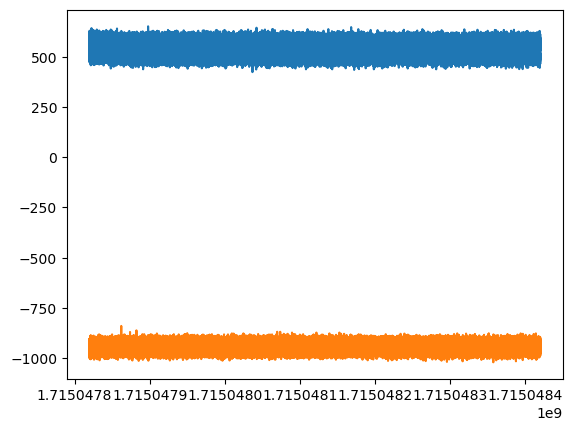

In [72]:
plt.plot(chan0)

In [69]:
chan0_t = channels_chunked.loc[0].index.get_level_values('t')

In [70]:
chan0_t

Index([1715047819.7287214,  1715047819.728742, 1715047819.7287621,
        1715047819.730578, 1715047819.7326124, 1715047819.7346852,
        1715047819.736707, 1715047819.7388449, 1715047819.7410133,
       1715047819.7428648,
       ...
       1715048420.3585691, 1715048420.3606865,  1715048420.362756,
       1715048420.3648536, 1715048420.3668463, 1715048420.3687923,
        1715048420.370959,  1715048420.373066,  1715048420.375042,
       1715048420.3771355],
      dtype='float64', name='t', length=293288)

In [27]:
# adc_i properties 
print(adc_i.shape, adc_i[0].shape)

(1002, 293288) (293288,)


In [22]:
len(adc_i[0])

293288

In [23]:
file['time_ordered_data']

NameError: name 'file' is not defined

In [25]:
adc_i[0].shape

(293288,)